# Exploratory analysis: Yields data

This notebook is for exploring different yield datasets and visualizing relationships between yield, rainfall, and water stress.

- [Figures that work](#another_cell)
- [Figures that dont work](#another_cell2)


Extra credit: Add parameters to legend like bottom of this doc: https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html

Last updated: 10 July 2020

## Imports

In [1]:
# import packages and set working directory
import numpy as np
import matplotlib.pyplot as plt
import os
from math import exp
import pandas as pd
import seaborn as sns
import proplot as plot
import sys
from scipy.stats import t
from scipy.optimize import curve_fit
import time
import progressbar

# We need to add the module path to our system path so 
# that our notebook can find our local objects and code:
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
# import objects
from farm import Climate
from farm import Soil
from farm import Crop
from farm import CropModel
from farm.functions import *

# set background color
plot.rc['figure.facecolor'] = 'white'
plot.rc.axesfacecolor = 'white'
plot.rc['savefig.transparent'] = 'False'

## Functions

Space to play with functions if needed

In [2]:
def total_rf_corr(n_sim = 1000, station = 'OL JOGI FARM', texture = 'clay loam', lgp=180, pd_sim=100): 
    """ Run simulations for a specific climate, soil, and crop.

    Usage: total_rf_corr(n_sim, pd_ic, station, texture, lgp, pd_sim)
           
    Default values:
        n_sim = 500 # Number of Simulations to Remove Initial Conditions [integer]
        pd_ic = 1 # Planting Date for Initial Conditions [Julian day]
        station = 'OL JOGI FARM' # Climatology [string]
        texture = 'loam' # Soil Type [string]
        lgp = 180 # Length of Growing Period [Days]
        pd_sim 100 # Planting Date for Simulation [Julian day]

    """
    # Part 1. Set conditions for IC runs
    n_sim = n_sim # change back to 1000 later
    planting_date = pd_sim 

    # Part 2. Initialize model with a climate, soil and crop
    climate = Climate(station=station)
    soil = Soil(texture=texture)
    crop = Crop(soil=soil, lgp=lgp)
    soil.set_nZr(crop)

    model = CropModel(crop=crop, climate=climate, soil=soil)
    model.run()
    o = model.output()

    # Part 3. Get the mean, SD soil moisture and run the simulations to remove IC
    s0_mean, s0_std = average_soil_moisture(model, n_sims=n_sim, doy=planting_date)
    models = [CropModel(crop=crop, climate=Climate(), soil=soil) for i in np.arange(n_sim)]
    
    # Part 4. Run the actual simulations
    output = [model.run(s0=s0_mean, do_output=True, planting_date=planting_date) for model in models]

    # Part 5. Subset the growing period and get avg stress, total rf
    start = 21 
    end = start + lgp
    avg_stress = [df[start:end]['stress'].mean() for df in output]
    total_stress = [df[start:end]['stress'].sum() for df in output]
    
    total_rf = [df[start:end]['R'].sum() for df in output]
    #print(total_rf)

    return output, avg_stress, total_stress, total_rf

## Analysis

<a id='another_cell'></a>
### 1. Yield vs. DTM relationship using RidgeToReef Hybrid yields dataset

In [4]:
hybrid_data = pd.read_csv('../data/Yields/hybrid_yields.csv')

#plot_lin_regression(hybrid_data.days_to_maturity, hybrid_data.yield_kg_ha, 'days_to_maturity', 'yield_kg_ha', hybrid_data,'Days to Maturity', 'Yield (kg/ha)', 
#                    'Linear Regression and Confidence Limits (0.95)', positive=False)

### 2. Seasonal rainfall, static stress and yield 

In [5]:
output, avg_stress, total_stress, total_rf = total_rf_corr()

data_tuples = list(zip(total_rf, avg_stress))
df = pd.DataFrame(data_tuples, columns=['TotalRF','AvgStress'])

#plot_lin_regression(df.TotalRF, df.AvgStress, 'TotalRF','AvgStress',df, 'Seasonal rainfall (mm)', 'Static stress', 'Relationship between rainfall and stress')

#### Convert stress values to yield

In [6]:
# make a column for yield values from stress
df['Yield'] = pd.Series([calc_yield(i) for i in avg_stress])

#plot_lin_regression(df.TotalRF, df.Yield, 'TotalRF', 'Yield',df, 'Seasonal rainfall (mm)', 'Yield (kg/ha)', 'Linear Regression and 95% Confidence Intervals')

#max(pd.Series([calc_yield(i) for i in avg_stress]))

#### Try normalizing yields

Kelly's comment: `"Can you normalize yield by max yield? Then we might think about a curve (which will end up being y = ax^c + b, where c is pretty close, but slightly less than 1."`

In [7]:
df.TotalRF
df['Yield_norm'] = df.Yield/max(df.Yield)

#plot_lin_regression(df.TotalRF, df.Yield_norm, 'TotalRF', 'Yield_norm',df, 'Seasonal rainfall (mm)', 'Yield normalized by max yield', 'Linear Regression and 95% Confidence Intervals')

### 3. Fit curves: Rainfall and yield (still static stress)

#### Polynomial fit

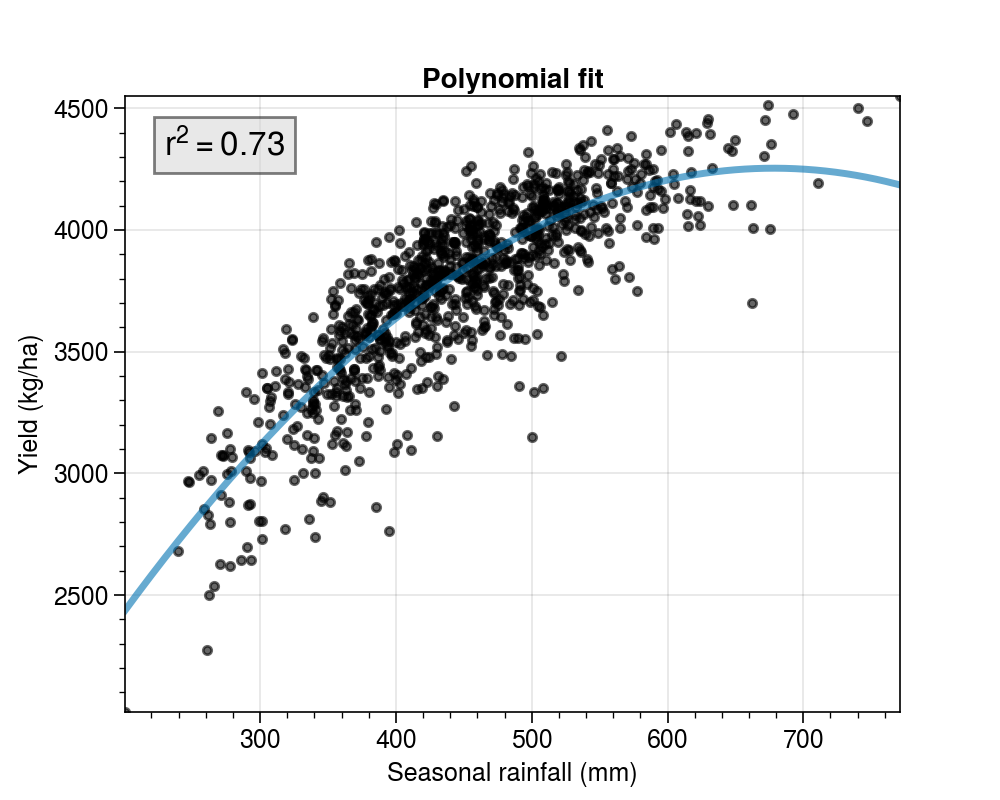

In [8]:
plot_polyfit(x=df.TotalRF, y=df.Yield, degree=2)

#### Power law fit

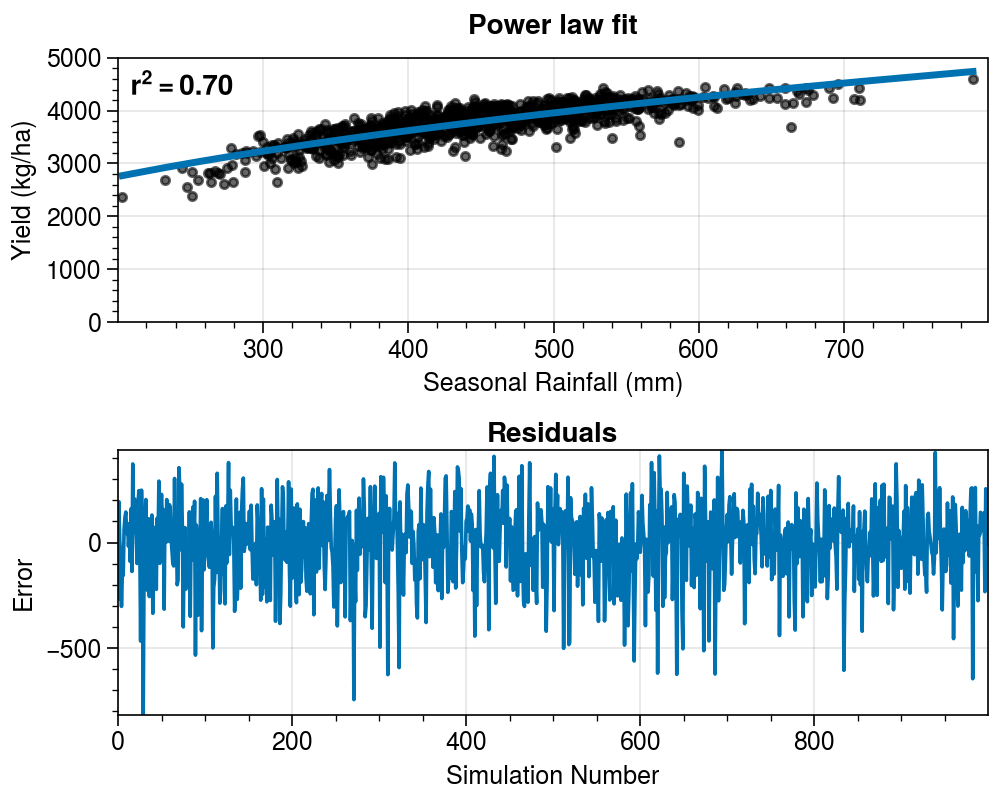

In [8]:
x=df.TotalRF
y=df.Yield

power_law_fit(x,y,'Seasonal Rainfall (mm)', 'Yield (kg/ha)', 'Power law fit')

# confidence intervals around line?

#### Adding van Ittersum data

### 4. Update hybrid yields datasets

In [9]:
hybrid_data = pd.read_csv('../data/Yields/hybrid_yields_v2.csv', usecols = ['VARIETY','Yield_kg','DTM_Avg']).dropna()

hybrid_data
plot_lin_regression(hybrid_data.DTM_Avg, hybrid_data.Yield_kg, 'DTM_Avg','Yield_kg', hybrid_data)


ValueError: Usecols do not match columns, columns expected but not found: ['Yield_kg', 'VARIETY']

Some thoughts on how to make these plots prettier:
- Black dots, gray error bars, blue line; [example](https://www.google.com/imgres?imgurl=https%3A%2F%2Fi.stack.imgur.com%2FNhMqj.jpg&imgrefurl=https%3A%2F%2Fstats.stackexchange.com%2Fquestions%2F85560%2Fshape-of-confidence-interval-for-predicted-values-in-linear-regression&tbnid=acETO_fACZOFqM&vet=12ahUKEwjSqOOLhY7pAhXnJjQIHSRSBLQQMygDegUIARDxAQ..i&docid=KblJqW3FklqejM&w=1668&h=993&q=confidence%20intervals%20linear%20regression%20python&ved=2ahUKEwjSqOOLhY7pAhXnJjQIHSRSBLQQMygDegUIARDxAQ).
- Nice example of docstrings for functions; [example](https://gist.github.com/rsnemmen/f2c03beb391db809c90f) or a shorter one [example](https://gist.github.com/rsnemmen/0eb32832c657c19e4d39).
- How to get different kinds of curves, but in R; [example](https://stats.idre.ucla.edu/r/faq/how-can-i-explore-different-smooths-in-ggplot2/)
- Maybe worth knowing the difference between lmplot and regplot in seaborn; [example](https://stackoverflow.com/questions/35948995/seaborn-lmplot-got-an-unexpected-keyword-argument-figsize)

### 5. Playing around with dynamic stress

In [10]:
climate = Climate(station='OL JOGI FARM')

soil = Soil(texture='clay loam')
crop = Crop(soil=soil, lgp=180)
soil.set_nZr(crop)

model = CropModel(crop=crop, climate=climate, soil=soil)
model.run()
o = model.output() # This is the correct length

mstr_memb, dstr_memb, yield_kg_ha = crop.calc_dstress(s=o.s, stress=o.stress) # average stress, dynamic stress, yield

# so this is the stress over a whole season
print(dstr_memb)

# and can be related to an end of season yield
print(yield_kg_ha)

0.3961917579822865
2572.2231109954596


In [11]:
def dyn_stress(n_sim = 1000, station = 'OL JOGI FARM', texture = 'clay loam', lgp=180, pd_sim=60): 
    """ Run simulations for a specific climate, soil, and crop.

    Usage: total_rf_corr(n_sim, pd_ic, station, texture, lgp, pd_sim)
           
    Default values:
        n_sim = 500 # Number of Simulations to Remove Initial Conditions [integer]
        pd_ic = 1 # Planting Date for Initial Conditions [Julian day]
        station = 'OL JOGI FARM' # Climatology [string]
        texture = 'clay' # Soil Type [string]
        lgp = 180 # Length of Growing Period [Days]
        pd_sim 100 # Planting Date for Simulation [Julian day]

    """
    # Part 1. Set conditions for IC runs
    n_sim = n_sim # change back to 1000 later
    planting_date = pd_sim 

    # Part 2. Initialize model with a climate, soil and crop
    climate = Climate(station=station)
    soil = Soil(texture=texture)
    crop = Crop(soil=soil, lgp=lgp)
    soil.set_nZr(crop)

    model = CropModel(crop=crop, climate=climate, soil=soil)
    model.run()
    o = model.output()

    # Part 3. Get the mean, SD soil moisture and run the simulations to remove IC
    s0_mean, s0_std = average_soil_moisture(model, n_sims=n_sim, doy=planting_date)
    models = [CropModel(crop=crop, climate=Climate(), soil=soil) for i in np.arange(n_sim)]
    
    # Part 4. Run the actual simulations
    output = [model.run(s0=s0_mean, do_output=True, planting_date=planting_date) for model in models]

    # Part 5. Subset the growing period and get avg stress, total rf
    start = 60 
    end = start + lgp
    avg_stress = [df[start:end]['stress'].mean() for df in output]
    total_stress = [df[start:end]['stress'].sum() for df in output]

    # dont need this but helpful for debugging
    total_rf = [df[start:end]['R'].sum() for df in output]
    avg_s = [df[start:end]['s'].mean() for df in output]
    sat = [df[start:end]['s'] for df in output]
    stress = [df[start:end]['stress'] for df in output]
    
    o = output
    
    # Part 6. Output the dynamic stress and yield values
    # prev crop.calc_dstress
    x = [crop.calc_dstress(s=df.s, stress=df.stress) for df in o] #for i in np.arange(n_sim)
    #print(x)
    return  x, total_rf, sat, stress, o, crop #output, avg_stress, total_stress, total_rf, mstr_memb, dstr_memb, yield_kg_ha

data, rf, sat, stress, o, crop = dyn_stress()

In [13]:
# manually define kc, a little janky
start = 60
end = 60 + 180
kc = o[1][start:end]['kc'].tolist()
#kc

In [14]:
# a list of total rf 
rf

# turn dynamic water stress data into a tuple
df = pd.DataFrame.from_records(data, columns =['AvgStress2','DynamicStress','Yield'])
df['RF'] = rf
df

x= df.RF
y= df.Yield

max(df.RF)

# Note to self, maybe try coding up the function as two different functions. See here: https://stats.stackexchange.com/questions/190107/curve-fit-with-logarithmic-regression-in-python. Can also check this out: https://stackoverflow.com/questions/3433486/how-to-do-exponential-and-logarithmic-curve-fitting-in-python-i-found-only-poly. 

# Also, bring functions into notebook to play around with. 


734.5567245444693

### The reason this didnt work before is because I was using the wrong output. Output came from rainfall_corr rather than dynamic stress. 

In [15]:
# scatter plot of raw data
max(df.Yield)

#df['Yield_norm'] = df.Yield/max(df.Yield)
#df1['Yield_norm'] = df1.Yield/max(df1.Yield)

plt.scatter(df1.RF, df1.Yield, color='yellow')
plt.scatter(df2.RF, df2.Yield, color='blue')
#plt.ylim(-.10,1.10)
#plt.xlim(100,900)
plt.title('Looking at raw relationship of rainfall and yield')
plt.ylabel('Yield normalized by max. yield')
plt.xlabel('Rainfall (mm)')

NameError: name 'df1' is not defined

## Curve fits for dynamic stress

0      191.375474
1     -333.530753
2       46.752696
3      241.881216
4     -516.298108
          ...    
995   -260.255016
996    265.452876
997    -63.946220
998     91.007687
999    286.706310
Length: 1000, dtype: float64

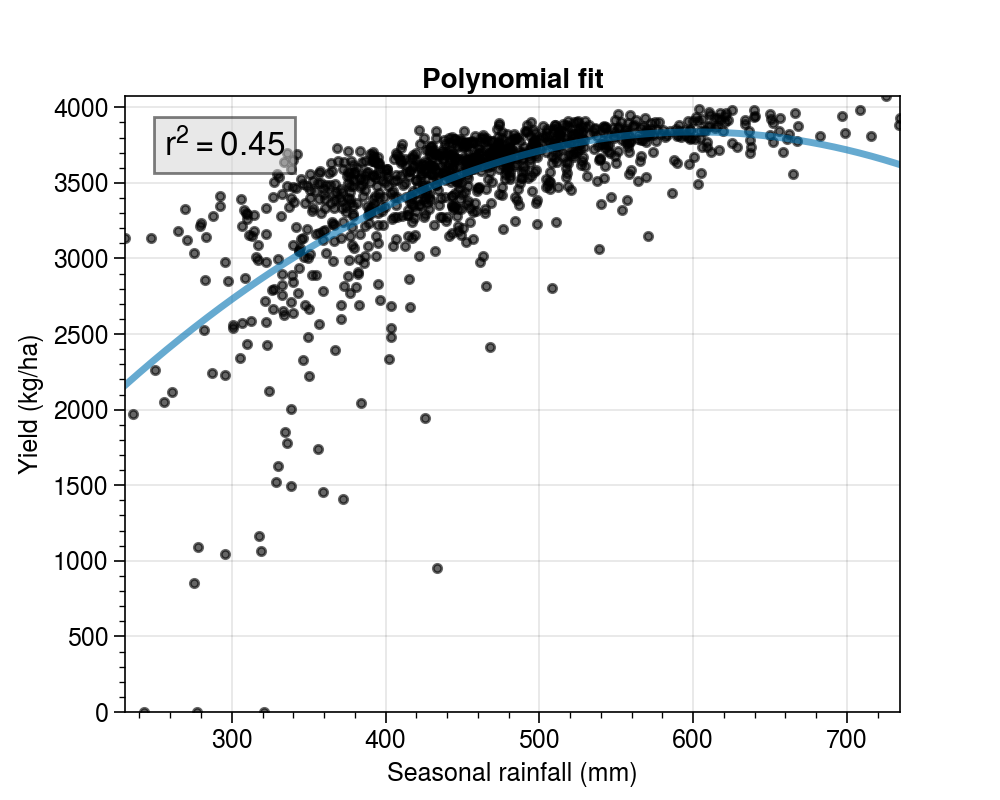

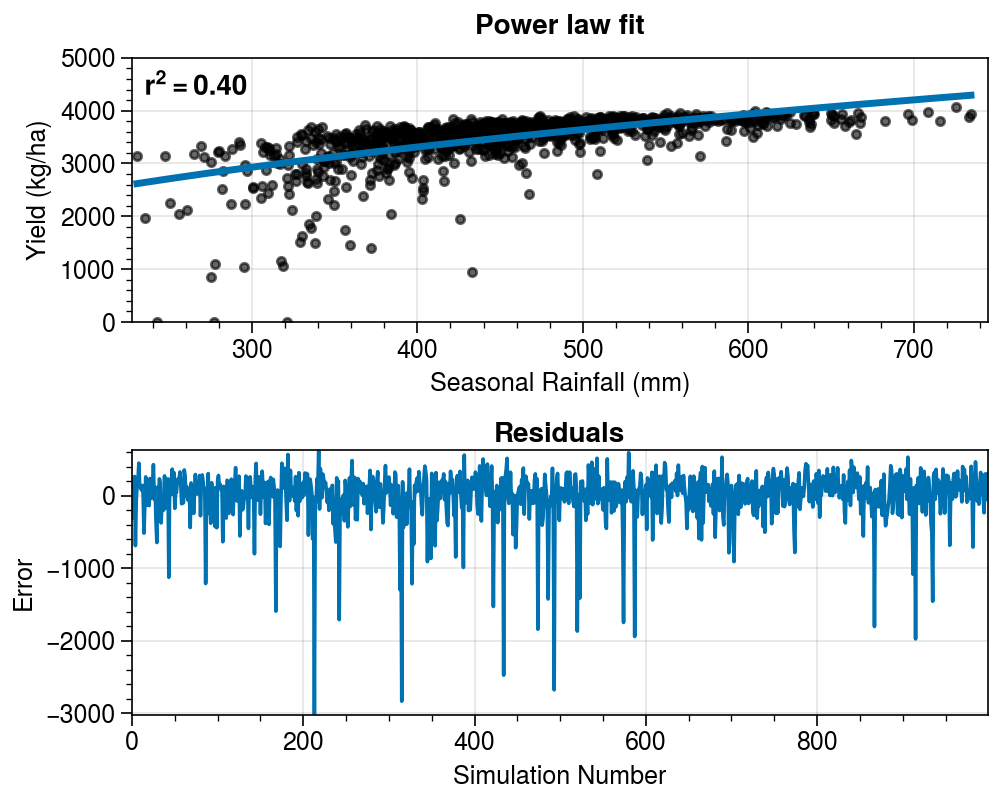

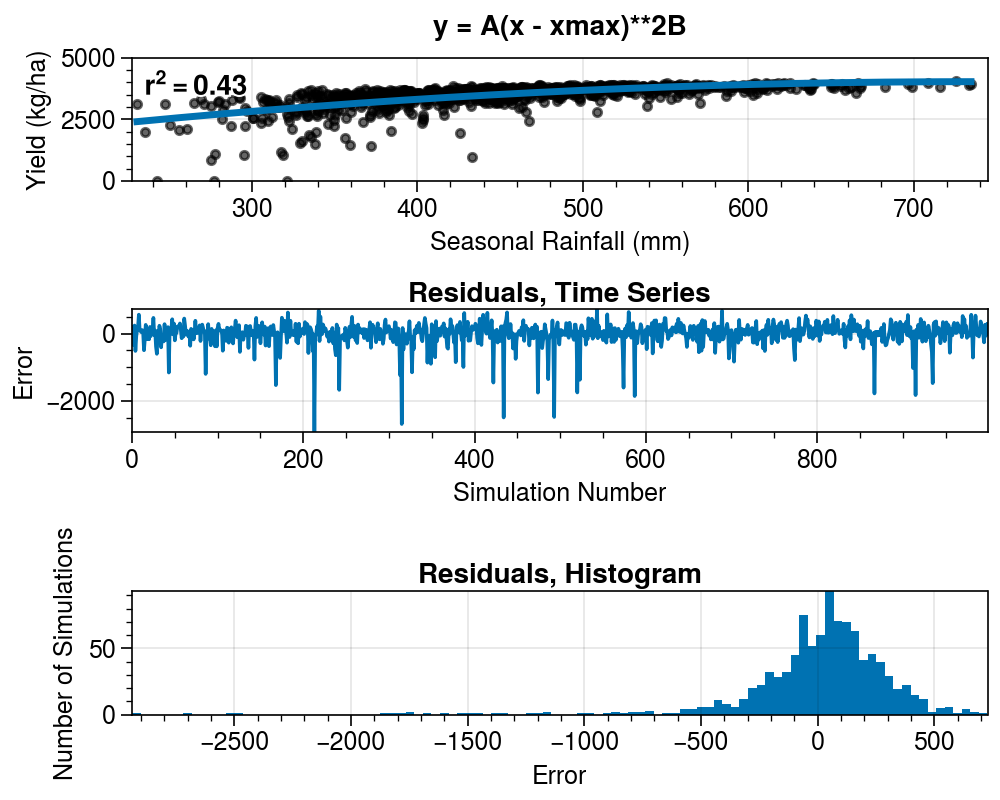

In [16]:
# now do lin regression
#plot_lin_regression(df.RF, df.Yield, 'RF', 'Yield',df, 'Total Rainfall (mm)', 'Yield (kg/ha)', 'Linear Regression and 95% Confidence Intervals')

# lin regression is not what we want; try quadratic
plot_polyfit(x=df.RF, y=df.Yield, degree=2)

# try power law
power_law_fit(df.RF, df.Yield,'Seasonal Rainfall (mm)', 'Yield (kg/ha)', 'Power law fit')

# New fit
plot_newfit(df.RF, df.Yield, 'Seasonal Rainfall (mm)', 'Yield (kg/ha)', 'New fit')

# plot histogram of the residuals




#### print stress time series


In [17]:
stress
sat

# convert list of lists into pandas dataframe
df_sat = pd.DataFrame(sat)
df_stress = pd.DataFrame(stress)

df_stress2 = df_stress.reset_index()
df_stress3 = df_stress2.reset_index()
df_stress3

df_stress3['sim_no'] = df_stress3['level_0'] + 1
df_stress3
df_stress4 = df_stress3.drop(['level_0','index'], axis=1)
df_stress4 # there must be  more efficient way to do this
bimod_stress = df_stress4[df_stress4.sim_no.isin(bimod.index)]
df_stress4[df_stress4.sim_no.isin(bimod.index)] # this is true, ignore index

len(bimod_stress) == len(bimod.index) # True! great!

bimod_stress #.reindex(df_sat4.sim_no)

bimod_stress = bimod_stress.reset_index()
bimod_stress

colnames = bimod_stress.sim_no.tolist()
colnames

bimod_stress

#bimod_sat['index'] = bimod_sat['sim_no']

#bimod_sat[1:].T.plot()

#bimod_sat.plot()
bimod_stress = bimod_stress.T.drop(['sim_no', 'index'],axis=0)
bimod_stress.columns = colnames
bimod_stress

# currently index goes from 21 to 180, which is day of simulation, but I want day of year
bimod_stress.index = bimod_stress.index - 20

for i in bimod_stress.columns:
    plt.figure()
    #plt.hist(df[i])
    bimod_stress[i].plot() # color='blue'
    plt.title([i])
    plt.ylabel('Static Stress')
    plt.xlabel('Day of season')
    #plt.savefig(str(i)+'_staticstress.png')

NameError: name 'bimod' is not defined

### 2b. How can we get a curve like Kaiyu's?

I played around with the R parameter <clay, ol jogi, 180d>: 
- 100 and 10 too large: dynamic water stress = 1.
- 1 = power law fit, r2=0.
- 0.5 = power law fit, r2 = 0.43
- 0.4 = 0.44
- 0.3 = 0.45
- 0.2 = 0.47 & 0.48 **This is the one to use**
- 0.1 = 0.42
- 0.09 = 0.43

Now try messing around with K parameter
- 0.4 = 0.45
- 0.6 = 0.45
- 1 = 0.52
- 0.1 = 0.58 but very funky.
- 0.2 = 0.53; there is still a horizontal line at 0 yield between 250-410 mm rf
- 0.3 = 0.53
- 0.4 = 0.48 **This is one to use if want failed seasons**

Question for Kelly: Do we want failed seasons to be showing up?

In [18]:
ds = list(df.DynamicStress)

In [19]:
# different yield measure

df['Yield2'] = pd.Series([calc_yield(i) for i in ds])

plot_lin_regression(df.DynamicStress, df.Yield, 'DynamicStress', 'Yield2',df, 'Dynamic stress (theta)', 'Yield (kg/ha)', 'Linear Regression and 95% Confidence Intervals')


1.0
m -4260.000000000004
b 4260.000000000001


(1.0, -4260.000000000004, 4260.000000000001)

<Figure size 500x400 with 0 Axes>

ConversionError: Failed to convert value(s) to axis units: 'Dynamic stress (theta)'

<Figure size 400x400 with 1 Axes>

In [20]:
#total_stress

# output, avg_stress, total_stress, total_rf, 

#mstr_memb, dstr_memb, yield_kg_ha = dyn_stress()

#data_tuples = list(zip(output, avg_stress, total_stress, total_rf, mstr_memb, dstr_memb, yield_kg_ha))
#df = pd.DataFrame(data_tuples, columns=['TotalRF','AvgStress', 'AvgStress2','DynamicStress','Yield'])

#data_tuples = list(zip(mstr_memb, dstr_memb, yield_kg_ha))
#df = pd.DataFrame(data_tuples, columns=['AvgStress2','DynamicStress','Yield'])


### 5. New regression figure with multiple DTMs

<a id='another_cell2'></a>

x-axis = average water stress \\
y-axis = average yield

This is all based on static stress

In [21]:
result = []

varieties = np.arange(70,220,5)
#varieties = [70, 90, 120, 140, 190, 210]

for i in varieties:
    
    output, avg_stress, total_stress, total_rf = total_rf_corr(n_sim = 100, station = 'OL JOGI FARM', texture = 'clay loam', lgp=i, pd_sim=60)
    data_tuples = list(zip(total_rf, total_stress, avg_stress))
    df = pd.DataFrame(data_tuples, columns=['TotalRF','TotalStress','AvgStress'])
    df['DTM'] = i
    result.append(df)
    
result = pd.concat(result)

# oops need this step
result = result.reset_index()
result# oops need this step
result = result.reset_index()
result

,level_0,index,TotalRF,TotalStress,AvgStress,DTM
0,0,0,122.037293,18.768086,0.268116,70
1,1,1,200.396464,5.137016,0.073386,70
2,2,2,169.290023,11.059174,0.157988,70
3,3,3,158.210563,9.692298,0.138461,70
4,4,4,190.915922,10.881384,0.155448,70
...,...,...,...,...,...,...
2995,2995,95,504.705671,53.789272,0.250183,215
2996,2996,96,612.039930,44.112331,0.205174,215
2997,2997,97,689.462835,14.458394,0.067248,215
2998,2998,98,356.831717,66.718541,0.310319,215


#### Brain dump on yield calculation:

- perhaps the problem is that average stress doesn't tell us enough
- What about cumulative stress?
- or stress above some value?
- the sum of stress above some value; maybe we don't worry about crops that are 10 days to maturity; or write this in as an exception
- or we could force lgp to be between certain values
- back to this idea though... it could be stress values above something? see what other papers did. but i dont feel like you can convert that to yield.

- Kelly's previous idea: Yield = stress^q: 
    1. Current equation: yield_kg_ha = -max_yield*stress + max_yield
    2. Drew’s: Y = Ymax(1-theta)

1. Should we just calculate dynamic stress like Drew did? If not, why not?

In [22]:
# add yield column
result['Yield'] = pd.Series([calc_yield(i) for i in result['AvgStress']])
result

,level_0,index,TotalRF,TotalStress,AvgStress,DTM,Yield
0,0,0,122.037293,18.768086,0.268116,70,3425.219418
1,1,1,200.396464,5.137016,0.073386,70,4336.553808
2,2,2,169.290023,11.059174,0.157988,70,3940.615224
3,3,3,158.210563,9.692298,0.138461,70,4032.000674
4,4,4,190.915922,10.881384,0.155448,70,3952.501771
...,...,...,...,...,...,...,...
2995,2995,95,504.705671,53.789272,0.250183,215,3509.145159
2996,2996,96,612.039930,44.112331,0.205174,215,3719.787404
2997,2997,97,689.462835,14.458394,0.067248,215,4365.277747
2998,2998,98,356.831717,66.718541,0.310319,215,3227.708032


In [23]:
# add categorical values for early, med, late
# There is probably a way more efficient way to do this
def category(x):
    if x < 120:
        return "Early"
    if 120 <= x <= 165:
        return "Medium"
    else:
        return "Late"
    
for row in result.DTM:
    result['Category'] = result.DTM.apply(lambda x: category(x))


Text(0.5, 1.0, 'Relationship between rainfall vs. yield of early, medium, late varieties')

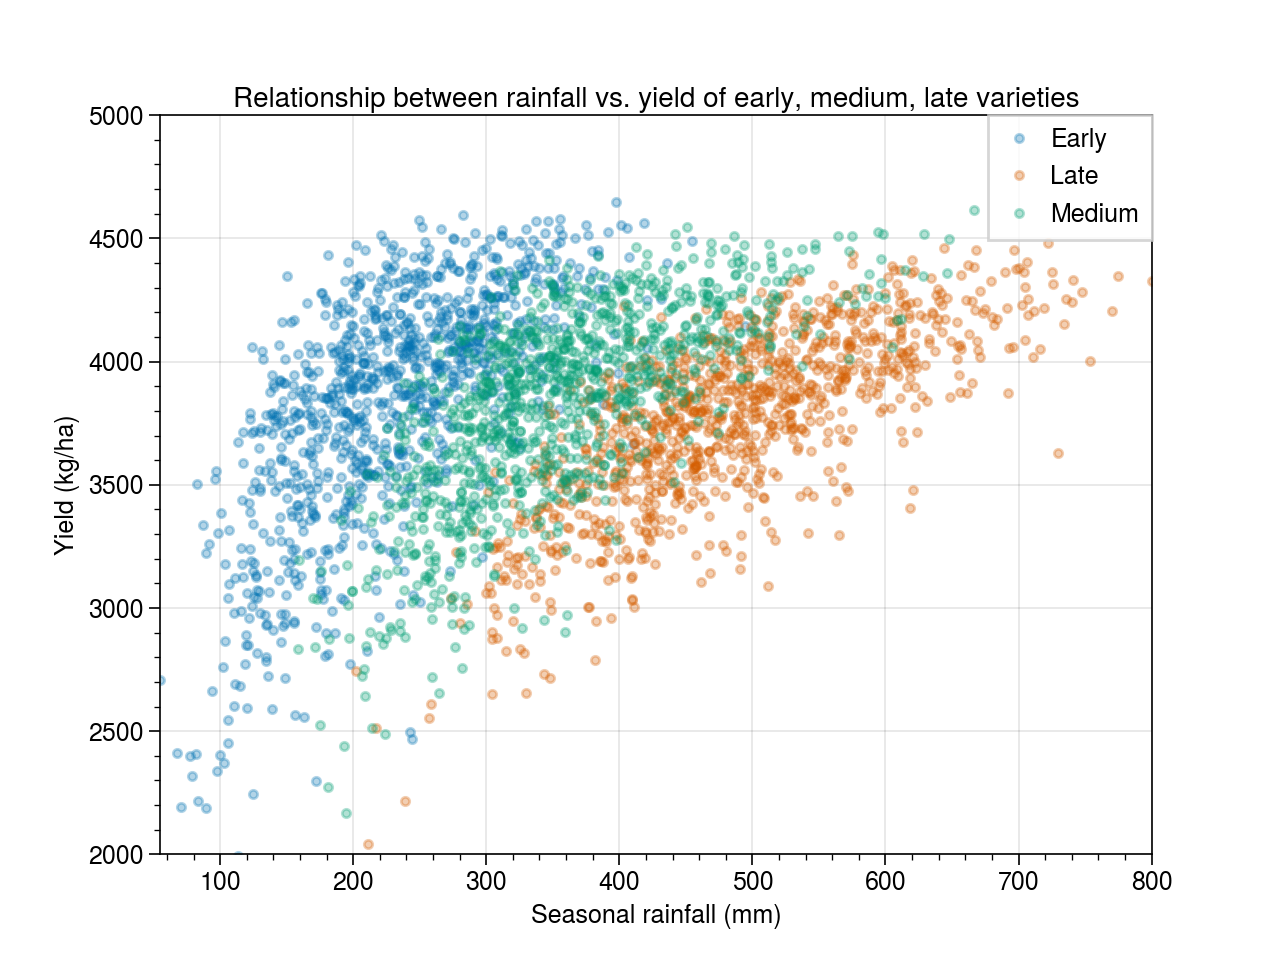

In [24]:
groups = result.groupby("Category")
for name, group in groups:
    plt.plot(group["TotalRF"], group["Yield"], marker="o", linestyle="", label=name, alpha=0.3)
plt.legend()

plt.xlabel('Seasonal rainfall (mm)')
plt.ylabel('Yield (kg/ha)')
plt.ylim(2000,5000)
plt.title('Relationship between rainfall vs. yield of early, medium, late varieties')

Text(0.5, 1.0, 'Relationship between total stress vs. yield of early, medium, late varieties')

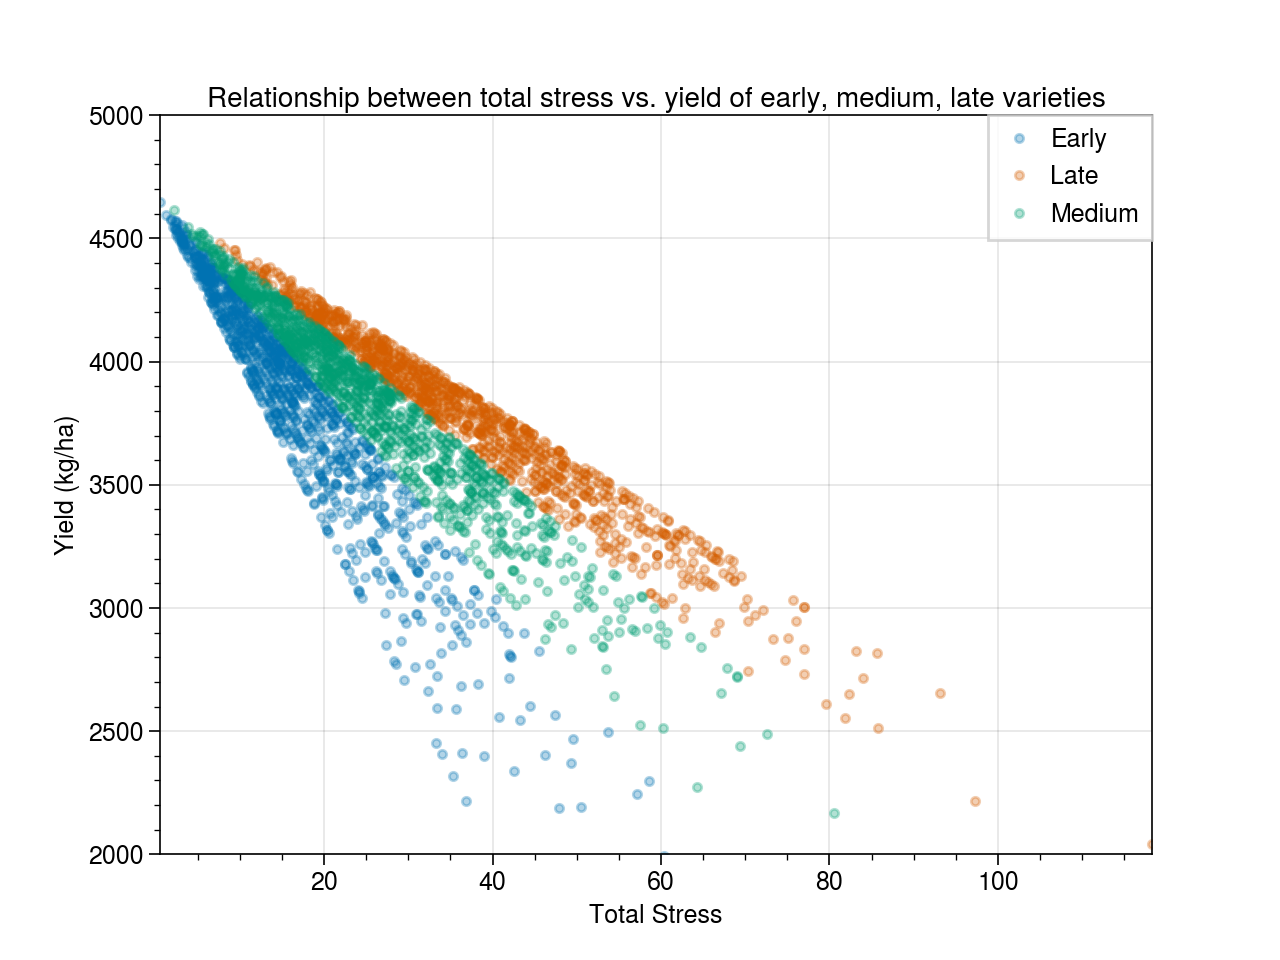

In [25]:
grouped_df = result.groupby("Category")
for key, item in grouped_df:
    plt.plot(item["TotalStress"], item["Yield"], marker="o", linestyle="", label=key, alpha=0.3)
    #print(grouped_df.get_group(key), "\n\n")
plt.legend()

plt.xlabel('Total Stress')
plt.ylabel('Yield (kg/ha)')
plt.ylim(2000,5000)
plt.title('Relationship between total stress vs. yield of early, medium, late varieties')



     level_0  index     TotalRF  TotalStress  AvgStress  DTM        Yield  \
0          0      0  122.037293    18.768086   0.268116   70  3425.219418   
1          1      1  200.396464     5.137016   0.073386   70  4336.553808   
2          2      2  169.290023    11.059174   0.157988   70  3940.615224   
3          3      3  158.210563     9.692298   0.138461   70  4032.000674   
4          4      4  190.915922    10.881384   0.155448   70  3952.501771   
..       ...    ...         ...          ...        ...  ...          ...   
995      995     95  307.906004     8.438966   0.073382  115  4336.570775   
996      996     96  137.680014    66.646891   0.579538  115  1967.761305   
997      997     97  242.741078    53.661255   0.466620  115  2496.220236   
998      998     98  296.911830    15.459437   0.134430  115  4050.868126   
999      999     99  305.603158    10.830919   0.094182  115  4239.228690   

    Category  
0      Early  
1      Early  
2      Early  
3      Early  


Text(0.5, 1.0, 'Relationship between average stress vs. yield of early, medium, late varieties')

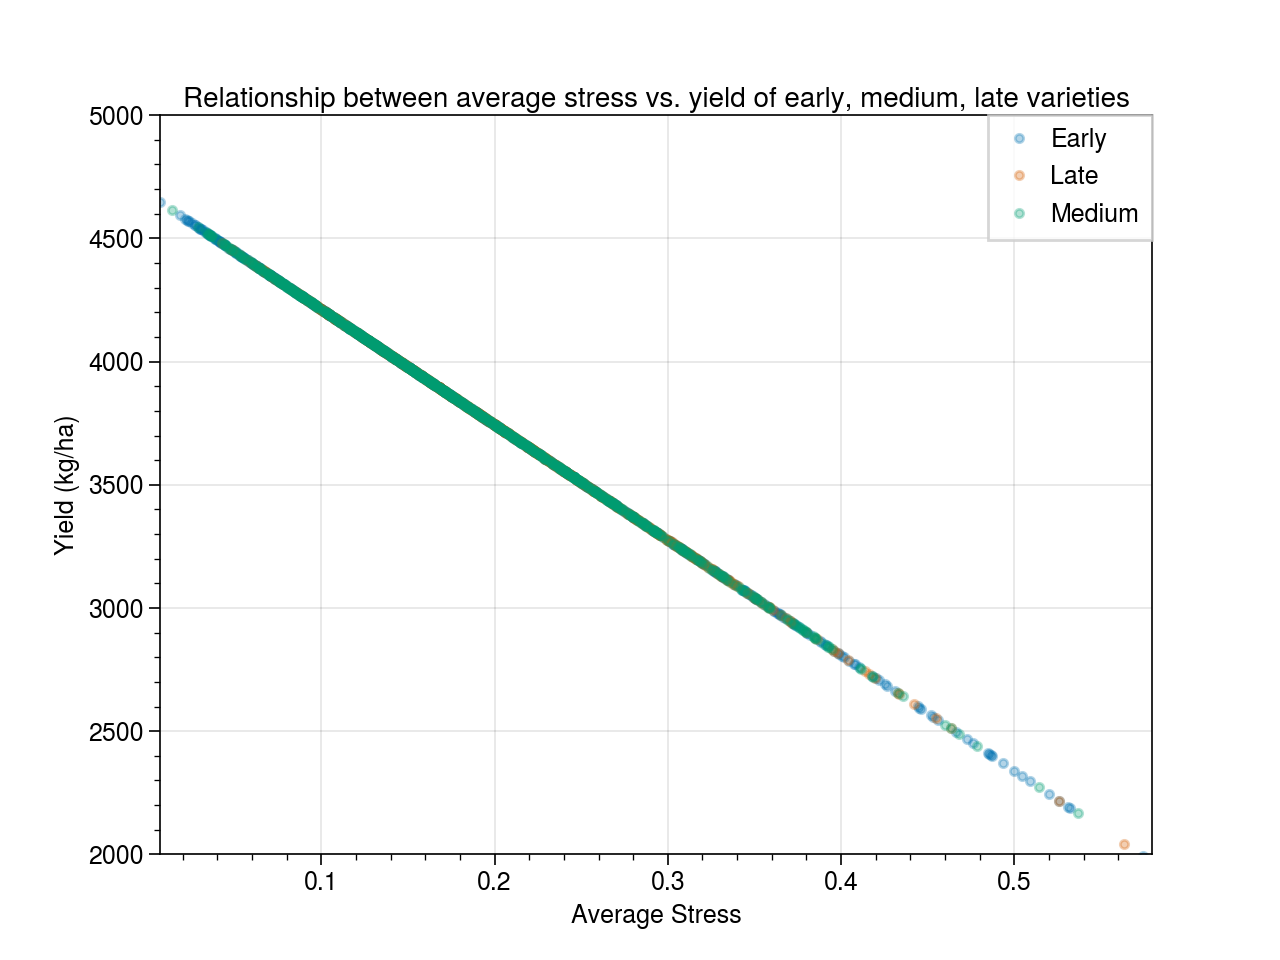

In [26]:
# this actually makes sense because it's the same equation governing the average stress vs. yield relationship
# for all the varieties

grouped_df = result.groupby("Category")
for key, item in grouped_df:
    plt.plot(item["AvgStress"], item["Yield"], marker="o", linestyle="", label=key, alpha=0.3)
    print(grouped_df.get_group(key), "\n\n")
plt.legend()

plt.xlabel('Average Stress')
plt.ylabel('Yield (kg/ha)')
plt.ylim(2000,5000)
plt.title('Relationship between average stress vs. yield of early, medium, late varieties')

Text(0.5, 1.0, 'Relationship between rainfall vs. yield of early, medium, late varieties')

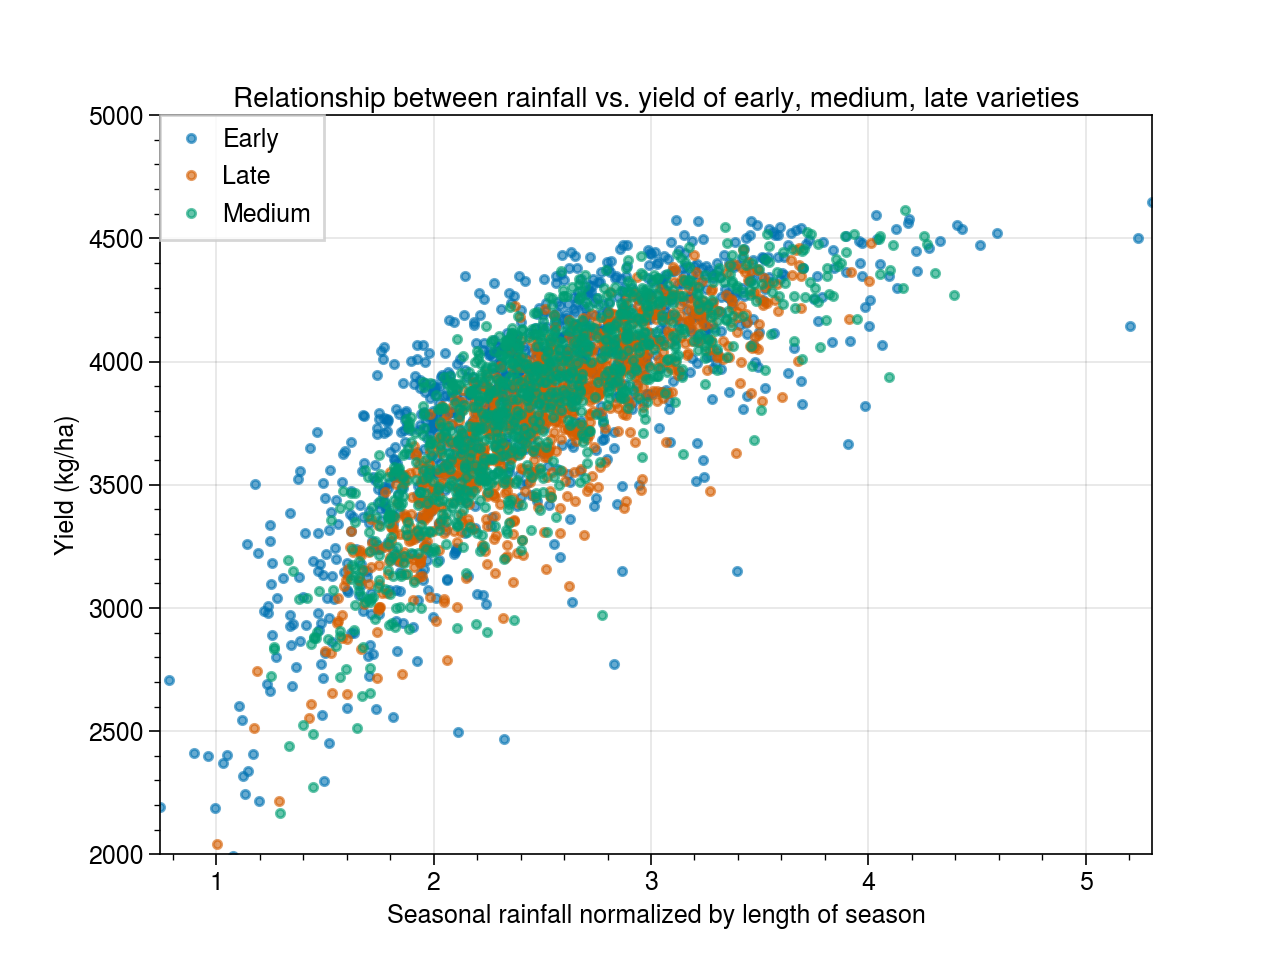

In [27]:
# maybe I need to normalize by length of season
result['TotalRF_norm'] = result['TotalRF']/result['DTM']
result

groups = result.groupby("Category")
for name, group in groups:
    plt.plot(group["TotalRF_norm"], group["Yield"], marker="o", linestyle="", label=name, alpha=0.6)
plt.legend()

plt.xlabel('Seasonal rainfall normalized by length of season')
plt.ylabel('Yield (kg/ha)')
plt.ylim(2000,5000)
plt.title('Relationship between rainfall vs. yield of early, medium, late varieties')


Text(0.5, 1.0, 'Relationship between stress vs. yield of early, medium, late varieties')

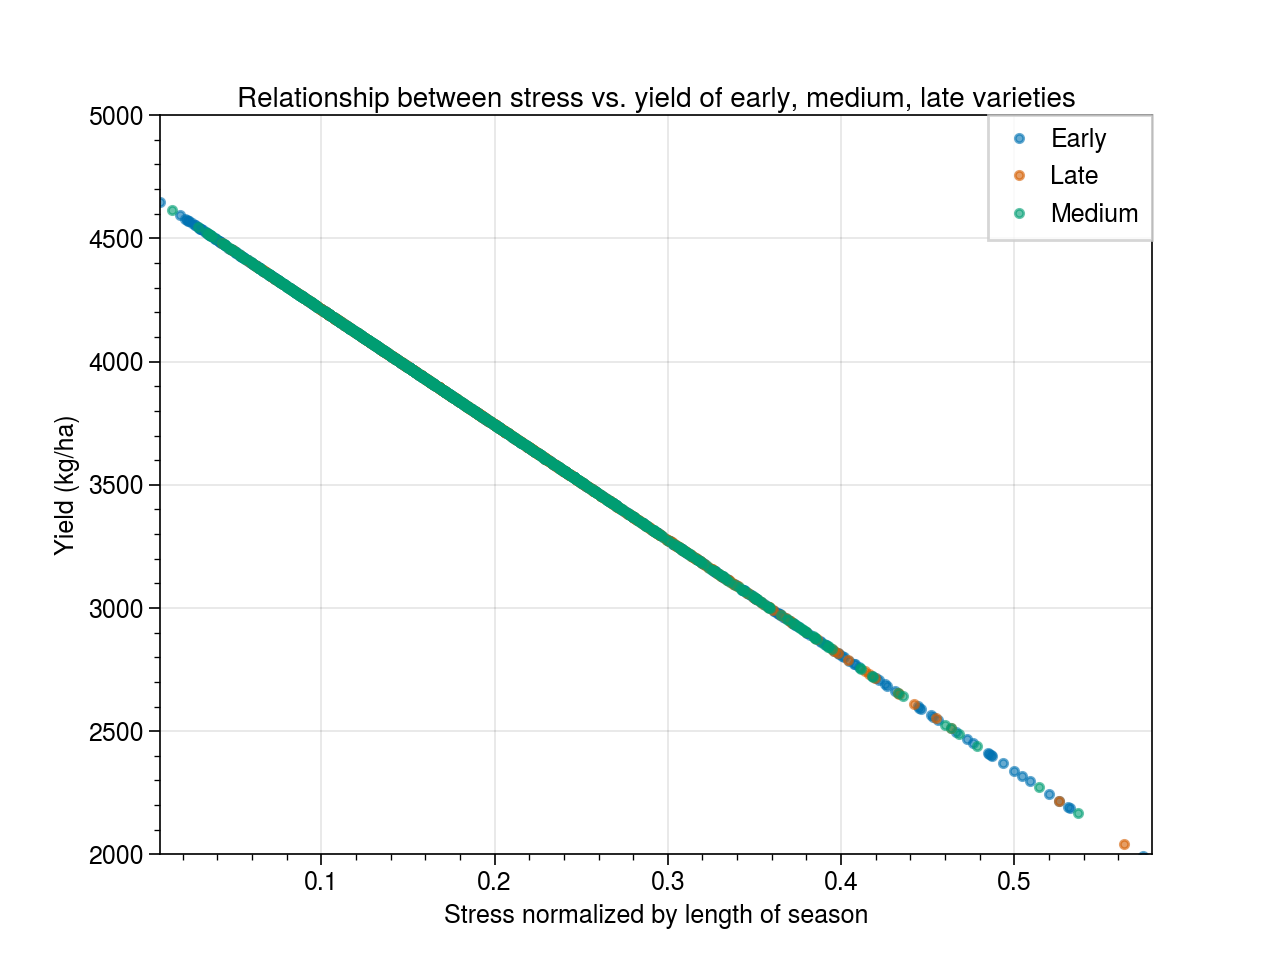

In [28]:
# maybe I need to normalize by length of season
result['TotalStress_norm'] = result['TotalStress']/result['DTM']
result

groups = result.groupby("Category")
for name, group in groups:
    plt.plot(group["TotalStress_norm"], group["Yield"], marker="o", linestyle="", label=name, alpha=0.6)
plt.legend()

plt.xlabel('Stress normalized by length of season')
plt.ylabel('Yield (kg/ha)')
plt.ylim(2000,5000)
plt.title('Relationship between stress vs. yield of early, medium, late varieties')


(2000.0, 5000.0)

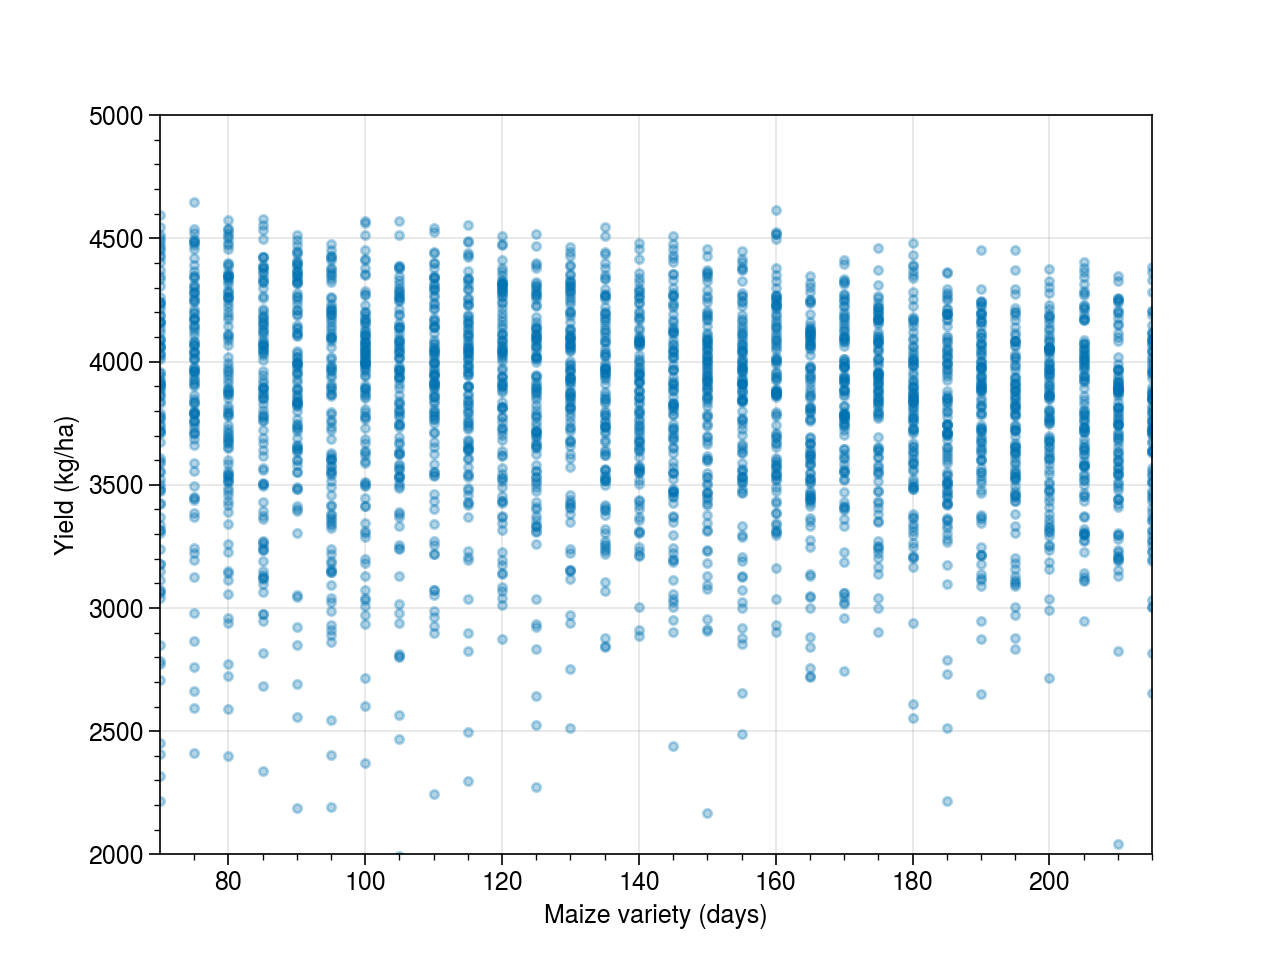

In [29]:
# what if I take lgp as the x-axis? yield as the y-axis?

plt.plot(result["DTM"], result["Yield"], marker="o", linestyle="", label='Category', alpha=0.3)
plt.xlabel('Maize variety (days)')
plt.ylabel('Yield (kg/ha)')
plt.ylim(2000,5000)
#plt.title('Relationship between stress vs. yield of early, medium, late varieties')

(0.0, 4500.0)

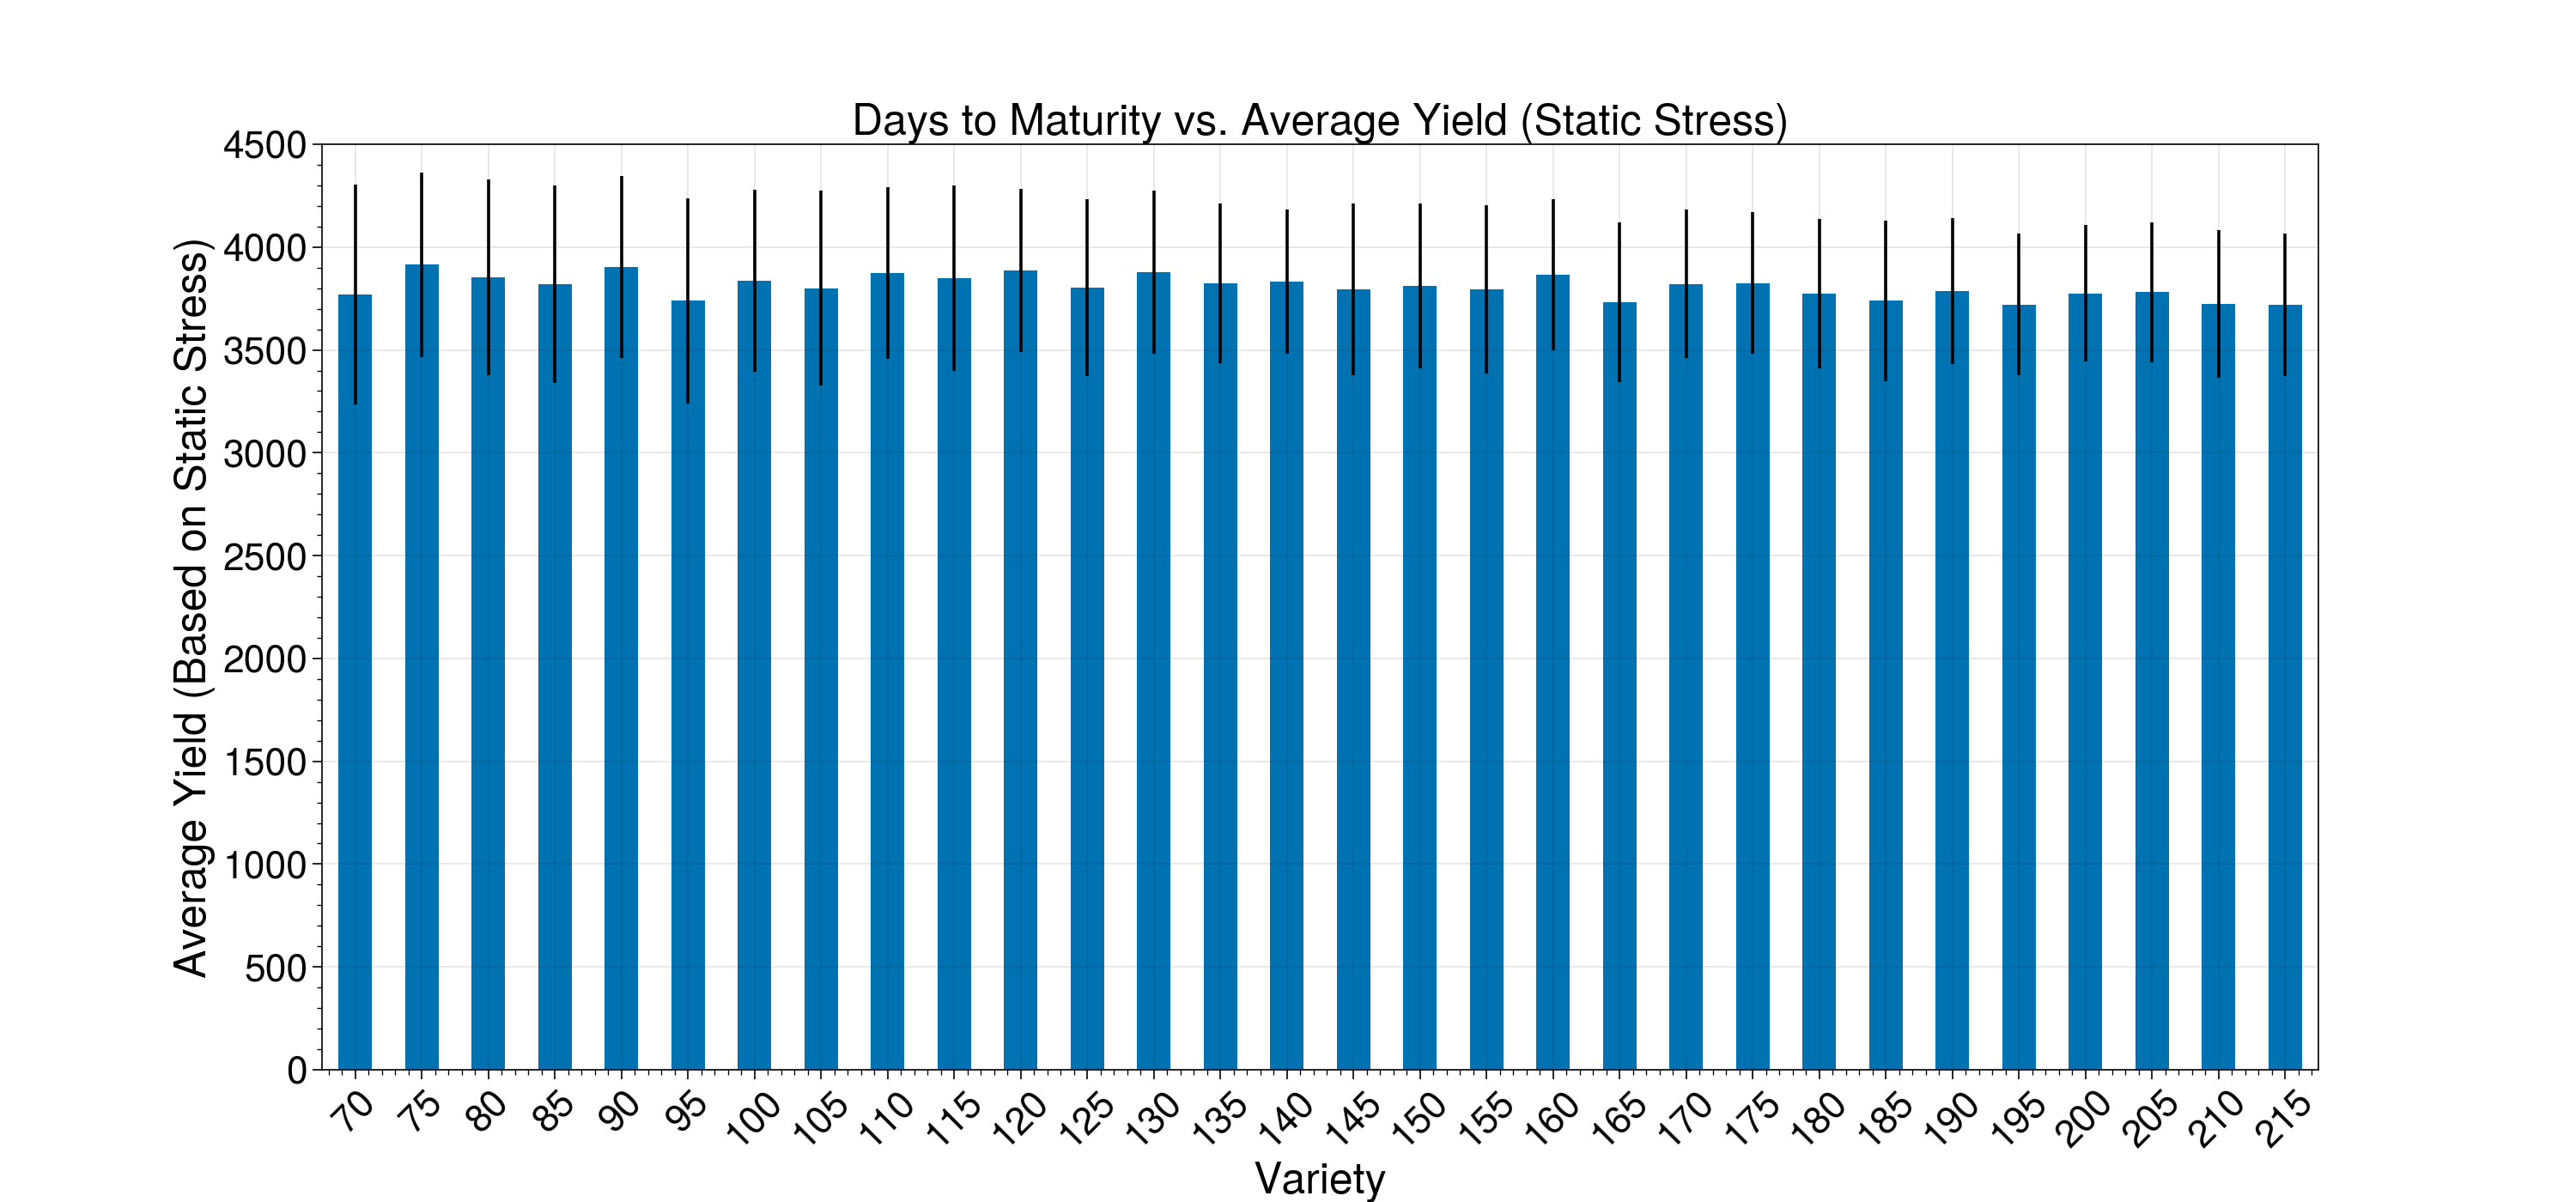

In [30]:
# can I plot the average yield per DTM. How would I do this?
# Houston we have a problem
result

std = result.groupby('DTM')['Yield'].std()

#result.groupby('DTM')['Yield'].mean().plot(marker='o')
result.groupby('DTM')['Yield'].mean().plot(figsize=(15,7),legend=False,kind="bar",rot=45,fontsize=16,yerr=std) # color="blue",

plt.ylabel('Average Yield (Based on Static Stress)', fontsize=18)
plt.xlabel('Variety', fontsize=18)
plt.title('Days to Maturity vs. Average Yield (Static Stress)', fontsize=18)
plt.ylim((0,4500))

# NOTE: new binning to change this figure so that it shows different climatologes 

In [60]:
result.DTM.value_counts()

215    100
205    100
80     100
90     100
100    100
110    100
120    100
130    100
140    100
150    100
160    100
170    100
180    100
190    100
200    100
210    100
75     100
85     100
95     100
105    100
115    100
125    100
135    100
145    100
155    100
165    100
175    100
185    100
195    100
70     100
Name: DTM, dtype: int64

## Need evolved calc yield here

0.3905396783804279
m 0.01875098888679605
b 0.29946317573930376


<Figure size 500x400 with 0 Axes>

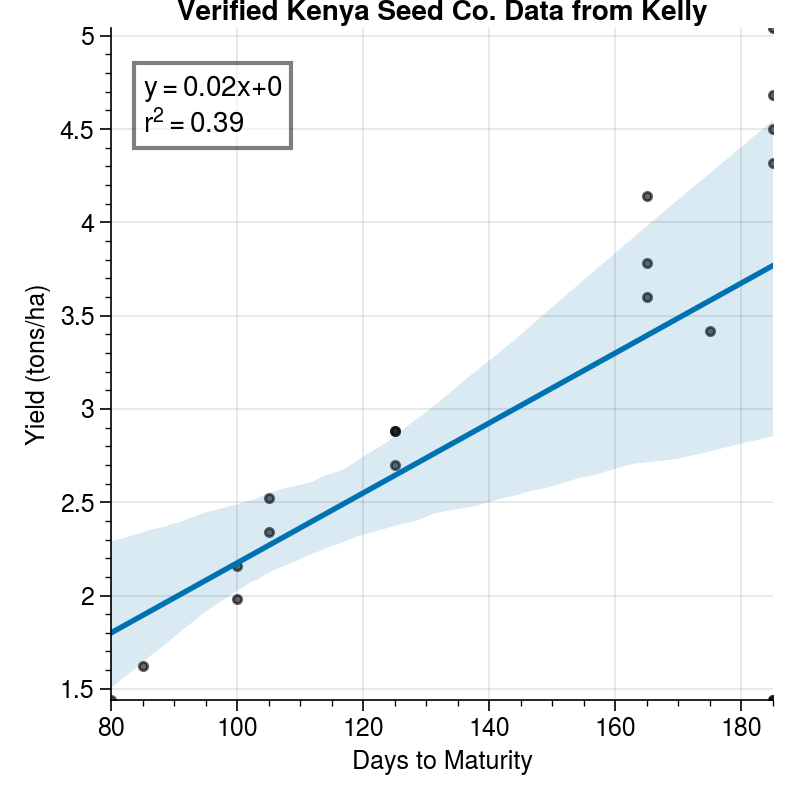

In [32]:
verified_hybrid_data = pd.read_csv('../data/Yields/hybrid_yields_verified.csv')
verified_hybrid_data


# convert to metric tons
verified_hybrid_data['yield_metric_tons'] = verified_hybrid_data.verified_yield_kg_acre/1000
verified_hybrid_data

p, m, b = plot_lin_regression(verified_hybrid_data.verified_days_to_maturity, verified_hybrid_data.yield_metric_tons, 
                              'verified_days_to_maturity', 'yield_metric_tons', verified_hybrid_data, 
                              85, 4.8, 'Days to Maturity', 'Yield (tons/ha)', 
                              'Verified Kenya Seed Co. Data from Kelly', positive=True)

In [33]:
def evolved_calc_yield(dtm=None, m = None, b = None):
    yield_kg_ha = m*dtm + b
    
    if dtm > 175:
        raise ValueError("days to maturity, {dtm} is larger than 175".format(
                dtm=dtm))
    if dtm < 68:
        raise ValueError("days to maturity, {dtm} is less than 68".format(
                dtm=dtm))
    
    return yield_kg_ha

evolved_calc_yield(100, m, b)
evolved_calc_yield(175,m,b)

3.5808862309286122

In [34]:
# Have to re-create the run_model function so that in crop.calc_dstress it uses my evolved_calc_yield function

def run_model(n_sim = 500, station = 'OL JOGI FARM', texture = 'clay loam', lgp=180, pd_sim=60): 
    """ Run simulations for a specific climate, soil, and crop.

    Usage: total_rf_corr(n_sim, pd_ic, station, texture, lgp, pd_sim)
           
    Default values:
        n_sim = 500 # Number of Simulations to Remove Initial Conditions [integer]
        pd_ic = 1 # Planting Date for Initial Conditions [Julian day]
        station = 'OL JOGI FARM' # Climatology [string]
        texture = 'loam' # Soil Type [string]
        lgp = 180 # Length of Growing Period [Days]
        pd_sim 100 # Planting Date for Simulation [Julian day]

    """
    # Part 1. Set conditions for IC runs
    planting_date = pd_sim 

    # Part 2. Initialize model with a climate, soil and crop
    climate = Climate(station=station)
    soil = Soil(texture=texture)
    crop = Crop(soil=soil, lgp=lgp)
    soil.set_nZr(crop)

    model = CropModel(crop=crop, climate=climate, soil=soil)
    model.run()
    o = model.output()

    # Part 3. Get the mean, SD soil moisture and run the simulations to remove IC
    s0_mean, s0_std = average_soil_moisture(model, n_sims=n_sim, doy=planting_date)
    models = [CropModel(crop=crop, climate=Climate(), soil=soil) for i in np.arange(n_sim)]
    
    # Part 4. Run the actual simulations
    output = [model.run(s0=s0_mean, do_output=True, planting_date=planting_date) for model in models]

    # Part 5. Subset the growing period because model starts 21 days before planting
    start = 60 
    end = start + lgp

    # dont need this but helpful for debugging
    avg_stress = [df[start:end]['stress'].mean() for df in output]
    total_stress = [df[start:end]['stress'].sum() for df in output]
    total_rf = [df[start:end]['R'].sum() for df in output]
    avg_s = [df[start:end]['s'].mean() for df in output]
    o = output
    
    # Part 6. Output the dynamic stress and yield values
    x = [crop.calc_dstress(s=df.s, stress=df.stress, Y_MAX = evolved_calc_yield(i, m, b)) for df in o] # I have no clue whether this will work
    
    return x, total_rf


In [35]:
# Now I have to re-run the simulations using the max yields from this relationship

varieties = np.arange(75,180,5) # 21 is a better number to work with because it divides by three
len(varieties)

result = []

for i in varieties:
    # note: bumping up to 200 sims per cultivar type takes several minutes to run
    # whereas 100 sims where varieties = np.arange(70,200,5) takes less than a minute.
    data, rf = run_model(n_sim = 100, station = 'OL JOGI FARM', texture = 'clay loam', lgp=i, pd_sim=60)
    df = pd.DataFrame.from_records(data, columns =['AvgStress','DynamicStress','Yield'])
    df['RF'] = rf
    df['Cultivar'] = i
    result.append(df)
    
result = pd.concat(result)
result

,AvgStress,DynamicStress,Yield,RF,Cultivar
0,0.153747,0.223235,1.324995,168.987231,75
1,0.248434,0.496868,0.858235,164.298173,75
2,0.081648,0.097593,1.539314,246.436932,75
3,0.121665,0.103484,1.529265,211.330869,75
4,0.023439,0.037790,1.641326,264.588839,75
...,...,...,...,...,...
95,0.141505,0.103948,3.208659,604.200327,175
96,0.143902,0.095084,3.240401,484.886264,175
97,0.283521,0.167024,2.982791,332.592536,175
98,0.109525,0.075824,3.309371,571.335179,175


Text(0, 0.5, 'Yield (kg/ha)')

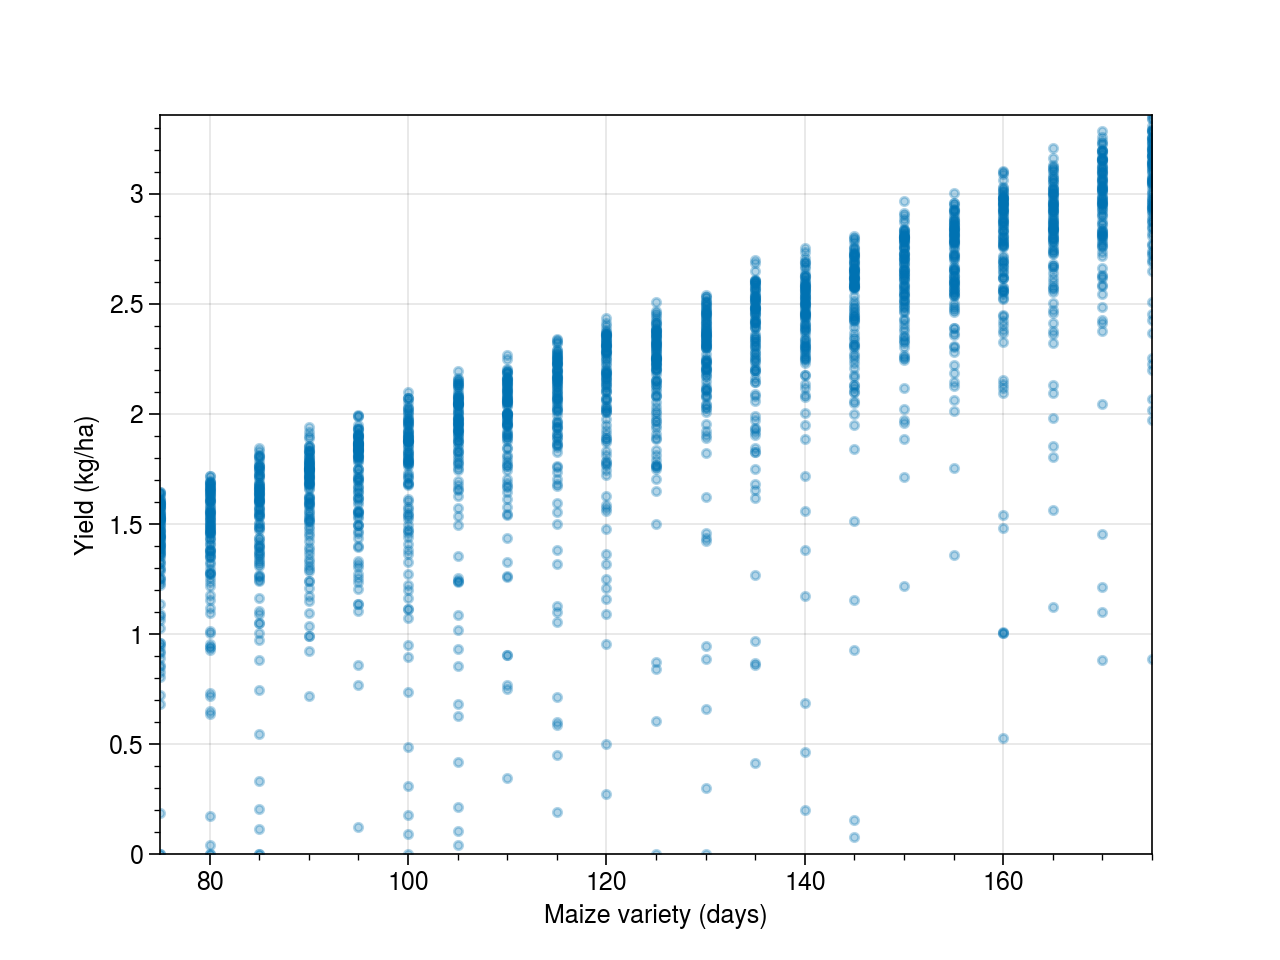

In [41]:
# what if I take lgp as the x-axis? yield as the y-axis?

plt.plot(result["Cultivar"], result["Yield"], marker="o", linestyle="", label='Category', alpha=0.3)
plt.xlabel('Maize variety (days)')
plt.ylabel('Yield (kg/ha)')
#plt.ylim(20,5000)
#plt.title('Relationship between stress vs. yield of early, medium, late varieties')

0.6170084115301635
m 489.35652197603497
b 2578.6549354501994


<Figure size 500x400 with 0 Axes>

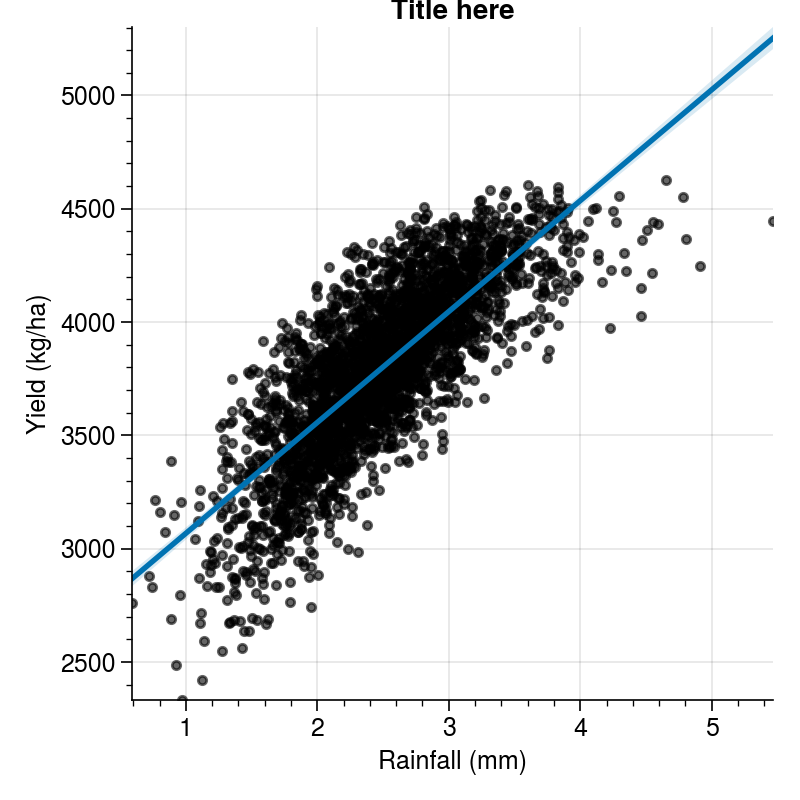

In [41]:
plot_lin_regression(result.TotalRF_norm, result.Yield, 'TotalRF_norm', 'Yield', data = result, 
                        x_lab = 'Rainfall (mm)', y_lab = 'Yield (kg/ha)', title = 'Title here', positive = True)





In [ ]:
# what if I use planting date as the x axis value

#import time
#import progressbar
#for i in progressbar.progressbar(range(simulations)):
#    time.sleep(0.02)
        
result = []

#varieties = np.arange(70,220,5)
#varieties = [75, 90, 120, 140, 190, 210]
planting_dates = np.arange(30,230,1)

for i in planting_dates:
    output, avg_stress, total_stress, total_rf = total_rf_corr(n_sim = 50, station = 'OL JOGI FARM', texture = 'loam', lgp=100, pd_sim=i)
    data_tuples = list(zip(total_rf, total_stress, avg_stress))
    df = pd.DataFrame(data_tuples, columns=['TotalRF','TotalStress','AvgStress'])
    df['PD'] = i
    result.append(df)

result = pd.concat(result)


In [ ]:
result

In [ ]:
# add yield column
result['Yield'] = pd.Series([calc_yield(i) for i in df['AvgStress']])
result

# add categorical values for early, med, late
# There is probably a way more efficient way to do this
def category(x):
    if x < 120:
        return "Early"
    if 120 <= x <= 165:
        return "Medium"
    else:
        return "Late"
    
#for row in result.DTM:
#    result['Category'] = result.DTM.apply(lambda x: category(x))


In [ ]:
plot_lin_regression(result.PD, result.Yield, 'PD', 'Yield', data = result, 
                        x_lab = 'PD', y_lab = 'Yield (kg/ha)', title = 'Title here', positive = True)



